## 4.3 PyTorch MNIST手写数据集识别

In [1]:
#下载手写数字图像数据MNIST

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".")  # data_home参数指定保存的位置



#### pytorch实现深度学习分为6个步骤：
1. 预处理数据
2. 创建DataLoader
3. 构建神经网络
4. 设置误差函数和优化方法
5. 设置学习和推理
6. 执行学习和推理

In [2]:
# 1. 预处理数据（拆分为图像数据和标签并标准化）

X = mnist.data / 255  # 0-255归一化为0~1
y = mnist.target

# 2020年12月1日
#由于MNIST数据集的更改，标签不是数字数据，因此
#通过以下方式转换为NumPy数组的数字类型

import numpy as np
y = np.array(y)
y = y.astype(np.int32)


该图像数据的标签为5


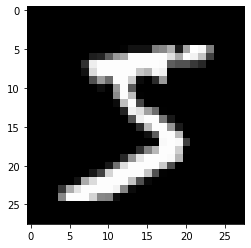

In [3]:
# 可视化第一个MNIST数据

# 2020年12月1日
# 在％matplotlib中的％后删除空格

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("该图像数据的标签为{:.0f}".format(y[0]))


In [5]:
# 2. 创建一个DataLoader

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 将数据分为训练集和测试集（6：1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 2.2 将数据转换为PyTorch Tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 使用数据和标签创建数据集
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 使用一组数据和标签创建Dataset
# 与Chainer的iterators.SerialIterator类似
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)



- fc1是一个具有28×28×1=784个神经元的输入层，并将其输出到100个神经元。（全连接）
- relu1通过ReLU转换fc1的100个神经元的输出。ReLU是输入为负时输出0、输入为正时直接输出的单元。
- 接下来，添加由100个输入-输出神经元组成的fc2层，并在relu2中通过ReLU进行转换。
- 最后，fc3层有10个神经元，输出对应于标记的0~9.

In [6]:
# 3. 建立网络
# Keras风格搭建网络

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)


Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
# 4. 设置误差函数及优化方法

from torch import optim

# 设置误差函数
loss_fn = nn.CrossEntropyLoss()  # 很多时候使用criterion作为变量名

# 选择学习权重参数时的优化方法
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [9]:
# 5. 设置学习和推理
# 5-1. 定义学习1轮所做的事情
# 相当于Chainer的training.Trainer()


def train(epoch):
    model.train()  # 将网络切换到训练模式

    # 从数据加载器中取出一个小批量并计算
    for data, targets in loader_train:
      
        optimizer.zero_grad()  # 初始梯度设置为0
        outputs = model(data)  # 输入数据并计算输出
        loss = loss_fn(outputs, targets)  # 计算输出和训练数据标签之间的误差
        loss.backward()  # 对误差进行反向传播
        optimizer.step()  # 更新权重

    print("epoch{}：结束\n".format(epoch))


In [10]:
# 5. 设置学习和推理
# 5-2. 定义一次推理中要做的事情
# 类似于Chainer的trainer.extend(extensions.Evaluator()


def test():
    model.eval()  # 将网络切换到推理模式
    correct = 0

    # 从数据加载器中取出一个小批量并计算
    with torch.no_grad():  # 输入数据并计算输出
        for data, targets in loader_test:

            outputs = model(data)  # 找到概率最高的标签

            # 推论
            _, predicted = torch.max(outputs.data, 1)  # 找到概率最高的标签
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 如果计算结果和标签一致，则计数加一

    # 输出正确答案率
    data_num = len(loader_test.dataset)  # 数据的总数
    print('\n测试数据的准确率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [11]:
# 在未学习的情况下推理测试数据
test()



测试数据的准确率: 908/10000 (9%)



In [12]:
# 6. 学习三轮
for epoch in range(3):
    train(epoch)

test()


epoch0：结束

epoch1：结束

epoch2：结束


测试数据的准确率: 9554/10000 (96%)



预测结果是2
这一图像数据的正确标签是2


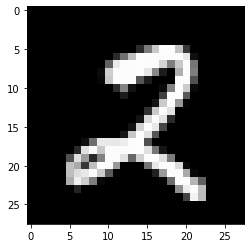

In [17]:
# 例如，推理第2018个图像数据

index = 2018

model.eval()  # 将网络切换到推理模式
data = X_test[index]
output = model(data)  # 输入数据并计算输出
_, predicted = torch.max(output.data, 0)  # 查找最大概率的标签

print("预测结果是{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("这一图像数据的正确标签是{:.0f}".format(y_test[index]))


In [12]:
#-----------------------------------------------

上面的网络构造是以Keras风格实现，但是如果要根据Chainer之类的输入实现灵活的计算，可以按照如下所示进行更改。“Define by Run”的特点是指模型可以根据输入数据x更改forward计算方式。

In [19]:
# 3. 构建网络
# 神经网络的设置（Chainer）风格
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # 与Chainer不同，None不被接受
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        # forwar可以改变，以匹配输入x
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output


model = Net(n_in=28*28*1, n_mid=100, n_out=10)  # 创建网络对象
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
